# Free Diving into Food Facts

### Imports needed for the processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import ast

matplotlib.rcParams.update({'font.size': 16})

Initiate the spark session and context.

In [2]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

Sanity check on the spark version and get the Spark UI link

In [3]:
spark

## Data information

Load data with Spark (used for the upcoming exploration)

In [4]:
foodFacts_spark = spark.read.format("csv")\
                            .option("delimiter", '\t')\
                            .option("encoding", "UTF-8")\
                            .option("header", "true")\
                            .load("data/en.openfoodfacts.org.products.csv")

Load data with pandas

In [5]:
#foodFacts_df = pd.read_csv("data/en.openfoodfacts.org.products.csv", sep='\t', encoding='UTF-8')

In [6]:
foodFacts_spark.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable 

In [7]:
print('There are in total {} products in this list, including duplicates.' .format(foodFacts_spark.count()))

There are in total 1030905 products in this list, including duplicates.


Lets observe the difference between generic_name and product_name

In [8]:
product_counts_generic = foodFacts_spark.withColumn('generic_name', lower(col('generic_name')))\
                                        .groupBy("generic_name")\
                                        .agg(count("*").alias("ProductCount"))\
                                        .sort(desc("ProductCount"))
product_counts_generic.show()

+--------------------+------------+
|        generic_name|ProductCount|
+--------------------+------------+
|                null|      938384|
|pâtes alimentaire...|         171|
|               bière|         127|
|pâtes alimentaire...|         123|
|beignets fourrés ...|         122|
|beignets fourrés ...|         113|
|jambon cuit supér...|         107|
|       chocolat noir|         106|
|        jus d'orange|          99|
|  aliment pour bébés|          94|
|           vin rouge|          92|
|pâte feuilletée a...|          85|
|    chocolat au lait|          83|
|lait demi-écrémé ...|          79|
|        bière blonde|          74|
|natürliches miner...|          72|
|        jus de pomme|          63|
|eau minérale natu...|          63|
|  pâtes alimentaires|          63|
|plat préparé en c...|          61|
+--------------------+------------+
only showing top 20 rows



In [9]:
product_counts_standard = foodFacts_spark.withColumn('product_name', lower(col('product_name')))\
                                         .groupBy("product_name")\
                                         .agg(count("*").alias("ProductCount"))\
                                         .sort(desc("ProductCount"))
product_counts_standard.show()

+--------------------+------------+
|        product_name|ProductCount|
+--------------------+------------+
|                null|       51183|
|               comté|         715|
|     filet de poulet|         696|
|     produit inconnu|         596|
|huile d'olive vie...|         580|
|aceite de oliva v...|         561|
|            emmental|         541|
|        jus de pomme|         516|
|                miel|         505|
|       huile d'olive|         502|
|          mayonnaise|         450|
|    filets de poulet|         437|
|           ice cream|         424|
|extra virgin oliv...|         415|
|            chocolat|         409|
|           spaghetti|         388|
|        jus d'orange|         373|
|              poulet|         365|
|             ketchup|         335|
|        pain complet|         311|
+--------------------+------------+
only showing top 20 rows



First observation is that the dataset contains a lot of undefined product. The name of the product is the most crucial information we need to actually determine what the row represents. Hence, we will drop these rows. (IDEA : regression to predict what product it was ?)

Second observation is that the product name will most likely be the interesting column as it regroups better similar products.

and third observation is that the dataset is constructed based on different languages...

In [10]:
foodFacts_spark = foodFacts_spark.where("product_name != 'null' AND product_name != 'Produit inconnu'")

In [11]:
product_counts_standard_cleaned = foodFacts_spark.withColumn('product_name', lower(col('product_name')))\
                                                 .groupBy("product_name")\
                                                 .agg(count("*").alias("ProductCount"))\
                                                 .sort(desc("ProductCount"))

product_counts_standard_cleaned.show()

+--------------------+------------+
|        product_name|ProductCount|
+--------------------+------------+
|               comté|         715|
|     filet de poulet|         696|
|huile d'olive vie...|         580|
|aceite de oliva v...|         561|
|            emmental|         541|
|        jus de pomme|         516|
|                miel|         505|
|       huile d'olive|         502|
|          mayonnaise|         450|
|    filets de poulet|         437|
|           ice cream|         424|
|extra virgin oliv...|         415|
|            chocolat|         409|
|           spaghetti|         388|
|        jus d'orange|         373|
|              poulet|         365|
|             ketchup|         335|
|        pain complet|         311|
|      tomato ketchup|         309|
|        potato chips|         300|
+--------------------+------------+
only showing top 20 rows



Let's observe if product having the same name overall have the same content. We'll focus on the Mayonnaise. The resulting dataset will be small enough to be put in a Pandas dataframe

# Mayonnaise analysis ;)

In [12]:
mayonnaise_comparison = foodFacts_spark.where("product_name = 'Mayonnaise'").toPandas()

In [13]:
mayonnaise_comparison.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0011110019141,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,1489062692,2017-03-09T12:31:32Z,1546199115,2018-12-30T19:45:15Z,Mayonnaise,None,None,...,None,24,24,None,None,None,None,None,None,None
1,0017548828119,http://world-en.openfoodfacts.org/product/0017...,usda-ndb-import,1489066739,2017-03-09T13:38:59Z,1557343065,2019-05-08T19:17:45Z,Mayonnaise,None,None,...,None,19,19,None,None,None,None,None,None,None
2,0021600103908,http://world-en.openfoodfacts.org/product/0021...,usda-ndb-import,1489094080,2017-03-09T21:14:40Z,1557343032,2019-05-08T19:17:12Z,Mayonnaise,None,None,...,None,24,24,None,None,None,None,None,None,None
3,0023005002107,http://world-en.openfoodfacts.org/product/0023...,kiliweb,1546122366,2018-12-29T22:26:06Z,1547475647,2019-01-14T14:20:47Z,Mayonnaise,None,None,...,None,None,None,None,None,None,None,None,None,None
4,0026700157387,http://world-en.openfoodfacts.org/product/0026...,usda-ndb-import,1489062118,2017-03-09T12:21:58Z,1557343007,2019-05-08T19:16:47Z,Mayonnaise,None,None,...,None,24,24,None,None,None,None,None,None,None


Let's compare the UK and FR nutrition scores.

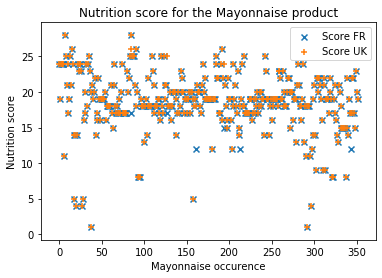

In [14]:
columns = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g']
clean_mayonnaise = mayonnaise_comparison.dropna(subset=columns).copy()
clean_mayonnaise[columns] = clean_mayonnaise[columns].applymap(int)

plt.scatter(range(len(clean_mayonnaise['nutrition-score-fr_100g'])), clean_mayonnaise['nutrition-score-fr_100g'], marker='x', label='Score FR')
plt.scatter(range(len(clean_mayonnaise['nutrition-score-uk_100g'])), clean_mayonnaise['nutrition-score-uk_100g'], marker='+', label='Score UK')
plt.legend()
plt.ylabel('Nutrition score')
plt.xlabel('Mayonnaise occurence')
plt.title('Nutrition score for the Mayonnaise product')
plt.show()

Let's try to highlight the difference

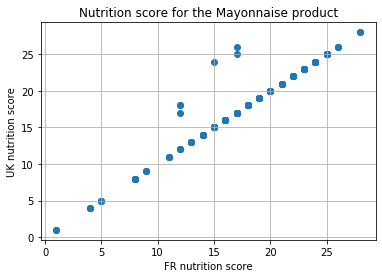

In [15]:
plt.scatter(clean_mayonnaise['nutrition-score-fr_100g'], clean_mayonnaise['nutrition-score-uk_100g'])
plt.ylabel('UK nutrition score')
plt.xlabel('FR nutrition score')
plt.title('Nutrition score for the Mayonnaise product')
plt.grid(True)
plt.show()

In [16]:
print ("We conclude that the UK and FR nutrition scores should be equal and that there are some errors in the dataset,"
       "which is not very surprising for an opensource dataset. Considering the nutrition score for "
       "the mayonnaise product, {}% of the data is ambiguous." \
       .format(100 - np.sum(clean_mayonnaise['nutrition-score-fr_100g'] == clean_mayonnaise['nutrition-score-uk_100g'])*100 / len(clean_mayonnaise)))

We conclude that the UK and FR nutrition scores should be equal and that there are some errors in the dataset,which is not very surprising for an opensource dataset. Considering the nutrition score for the mayonnaise product, 1.7045454545454533% of the data is ambiguous.


Let's do a similar analysis but for the content in saturated fat as the Mayonnaise product should containt a lot of fat.

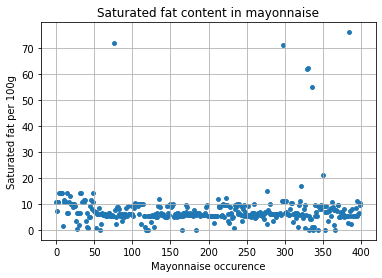

In [17]:
clean_mayonnaise = mayonnaise_comparison.dropna(subset=['saturated-fat_100g']).copy()
clean_mayonnaise['saturated-fat_100g'] = clean_mayonnaise['saturated-fat_100g'].map(float)

plt.scatter(range(len(clean_mayonnaise)), clean_mayonnaise['saturated-fat_100g'], marker='o',s=15)
plt.title('Saturated fat content in mayonnaise')
plt.xlabel('Mayonnaise occurence')
plt.ylabel('Saturated fat per 100g')
plt.grid(True)
plt.show()

Here we observe some divergence in the dataset with a few outliers. This may come from the fact that this mayonnaise product contains different types of mayonnaise, such as light mayonnaise etc.. <br>
Let's check

In [18]:
product_counts_standard_cleaned.filter(col('product_name').contains('mayonnaise')).show()

+--------------------+------------+
|        product_name|ProductCount|
+--------------------+------------+
|          mayonnaise|         450|
|     real mayonnaise|         116|
|mayonnaise à la m...|          69|
|    light mayonnaise|          37|
| mayonnaise de dijon|          25|
|  organic mayonnaise|          22|
|      mayonnaise bio|          17|
|   mayonnaise légère|          17|
|mayonnaise au citron|          15|
|   mayonnaise nature|          13|
|mayonnaise dressi...|          12|
|  mayonnaise allégée|          11|
|    mayonnaise light|          10|
|mayonnaise aux oeufs|          10|
|mayonnaise aux oe...|          10|
|thon sauce mayonn...|           9|
|macédoine de légu...|           9|
|   mayonnaise citron|           9|
|delikatess mayonn...|           9|
|mayonnaise à la m...|           8|
+--------------------+------------+
only showing top 20 rows



We remark that the different types of mayonnaise have different names, hence one can assume that the "mayonnaise" product only contains the standard mayonnaise.

Hence, this product has some divergence in at least the field representing the saturated fat. This may come from the fact that this is an opensource dataset, hence some people may have simply rounded the number that they read/analysed on the product list of content.

# Bio VS non-Bio

A lot of products claim to be bio. Different terms are used depending on the location (organic, bio, ...), but overall they all refer to the same fact that the product was mostly produced in compliance with the standards of [organic farming](https://en.wikipedia.org/wiki/Organic_farming). In the common knowledge, people often claim that organic or bio products are healthier than non-organic products.

In the upcoming analysis, we will try to investigate whether this statement is quantitavely true or if sometimes companies take advantage of the "bio" acronym to gain market shares.

We will conduct this analysis by investigating different columns of interest: 

* As stated above, organic products should undergo as little tratment as possible, inducing a more natural product. This should directly be represented by a lower capacity in additives. Hence as a first step we will assess whether there is a different in additives between bio and normal products.
* ADD MORE ANALYSIS

### Additives

First we extract the product_name and additives_tags columns and clean it to have no undefined values.

In [19]:
additives_df = foodFacts_spark.select(['product_name','additives_en']).toPandas()

In [20]:
additives_df.head()

,product_name,additives_en
0,Vitória crackers,None
1,Cacao,None
2,moutarde au moût de raisin,E160c - Paprika extract
3,Sfiudwx,None
4,Sauce Sweety chili 0%,None


We remark that a lot of products do not contain any additives. One should be careful with this as this could be either that the product indeed does not contain any additives, or simply because the data is missing this information.

As we are trying to compare the different additives present in the bio and normal products and not quantizing how many products of these two categories contain additives, we can drop the rows not containing this information.

In [21]:
additives_df = additives_df.dropna()
additives_df.shape

(243335, 2)

In [22]:
additives_df.head()

,product_name,additives_en
2,moutarde au moût de raisin,E160c - Paprika extract
14,Solène céréales poulet,"E150 - Caramel,E160a - Alpha-carotene,E202 - P..."
21,Crème dessert chocolat,E406 - Agar
37,Suedois saumon,"E300 - Ascorbic acid,E503 - Ammonium carbonates"
42,Salade shaker taboulé,E202 - Potassium sorbate


Now we create a new column identifying if the product is bio or not

In [23]:
organic_keywords = 'organic|bio'
additives_df['bio_product'] = additives_df['product_name'].str.contains(organic_keywords)

In [24]:
nNormal, nBio = additives_df['bio_product'].value_counts()
print('There are {} bio products and {} normal products with the additive column filled.' .format(nBio, nNormal))

There are 1400 bio products and 241935 normal products with the additive column filled.


We observe a highly unbalanced dataset between products being organic and products not being organic. This will be taken into account for the upcoming analysis.

The additives_tags contains a string being a list. Let's process this column to enable an array, and then exploding this column to have a single element per row in this column.

In [25]:
additives_df['additives_en'] = additives_df['additives_en'].apply(lambda x: list(x.split(",")))
additives_df_exploded = additives_df.explode('additives_en')

In [26]:
additives_df_exploded.head()

,product_name,additives_en,bio_product
2,moutarde au moût de raisin,E160c - Paprika extract,False
14,Solène céréales poulet,E150 - Caramel,False
14,Solène céréales poulet,E160a - Alpha-carotene,False
14,Solène céréales poulet,E202 - Potassium sorbate,False
14,Solène céréales poulet,E316 - Sodium erythorbate,False


Let's create a dataframe for bio products and another dataframe for non-bio products.

In [27]:
mask_bio = additives_df_exploded['bio_product'] == True
additives_bio_df = additives_df_exploded[mask_bio]
additives_normal_df = additives_df_exploded[~mask_bio]

In [28]:
additives_bio_df = additives_bio_df.groupby('additives_en') \
                                   .count() \
                                   .sort_values('product_name', ascending=False) \
                                   .reset_index() \
                                   .drop(columns='bio_product') \
                                   .rename(columns={'additives_en' : 'additive', "product_name" : "count"})
    
additives_normal_df = additives_normal_df.groupby('additives_en') \
                                         .count() \
                                         .sort_values('product_name', ascending=False) \
                                         .reset_index() \
                                         .drop(columns='bio_product') \
                                         .rename(columns={'additives_en' : 'additive', "product_name" : "count"})

First let's observe the 5 most used additive in Bio and non-Bio products, which is not biased by the unbalancing of the dataset.

In [29]:
most_used_bio = additives_bio_df['additive'][:5]
most_used_normal = additives_normal_df['additive'][:5]
print("The most used additives for bio products are : \n{} \n\n\n"
      "The most used additives for normal products are : \n{}" .format(most_used_bio, most_used_normal))

The most used additives for bio products are : 
0      E330 - Citric acid
1          E440 - Pectins
2        E322 - Lecithins
3          E440i - Pectin
4    E300 - Ascorbic acid
Name: additive, dtype: object 


The most used additives for normal products are : 
0          E330 - Citric acid
1            E322 - Lecithins
2            E322i - Lecithin
3          E415 - Xanthan gum
4    E500 - Sodium carbonates
Name: additive, dtype: object


We already observe a difference from the top 5 used additives for bio product vs normal product. Let's try to visualize the global picture

First we compute the proportion of each additive in its own dataset

In [30]:
additives_bio_df['proportion'] = additives_bio_df['count'] / additives_bio_df['count'].sum()
additives_normal_df['proportion'] = additives_normal_df['count'] / additives_normal_df['count'].sum()

Let's observe the results, taking the normal products as a reference.

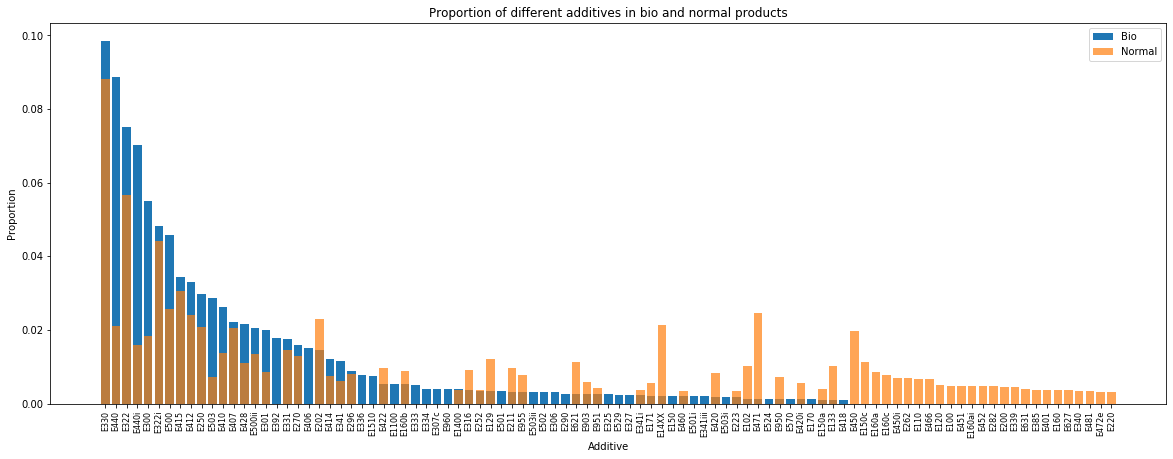

In [31]:
n_to_plot = 70

figure = plt.figure(figsize=(20,7))

additive_tag_bio = additives_bio_df.additive.apply(lambda x: x.split(" ")[0])
additive_tag_normal = additives_normal_df.additive.apply(lambda x: x.split(" ")[0])

plt.bar(additive_tag_bio[:n_to_plot], additives_bio_df.proportion[:n_to_plot], label='Bio')
plt.bar(additive_tag_normal[:n_to_plot], additives_normal_df.proportion[:n_to_plot], label='Normal', alpha=0.7)

plt.title('Proportion of different additives in bio and normal products')
plt.xlabel('Additive')
plt.ylabel('Proportion')
plt.legend()
plt.xticks(rotation = (90), fontsize = 8, va='top')
plt.show()

Many different analysis can be conducted from this graph.

* Let's analyze of of the spike present for the bio products and not for the normal products. The most obvious one is with the E440 and E440i additives. With a quick search online, we determine that this specific additive is [Pectin](https://en.wikipedia.org/wiki/Pectin). This specific additive is also used for [medicine](https://www.webmd.com/vitamins/ai/ingredientmono-500/pectin) and is hence not harmful at all.

* Another big peak present for bio products and not for normal products is with the E300 additive. Again, a quick search online revealed that this additive represent [ascorbic acid](https://www.webmd.com/drugs/2/drug-322/ascorbic-acid-vitamin-c-oral/details) and is known to be an antioxident, hence again not harmful at all.

* We observe that going down the most present additives, the normal products contains some additives that are not present at all in bio products. Let's observe some of them a bit deeper
    - Let's observe the E471 additive. We found that this additive represent the Mono- and diglycerides of fatty acids. It was set not to be harmful but is still prohibited in biological food in the EU due to its source from fatty acids. ([source in french](https://www.additifs-alimentaires.net/E471.php)). The presence of this additive in the dataset even if it is prohibited in the EU may be explained by the fact that it may not be prohibited in other countries, such as in the United States.
    - E450 represent the Diphosphates and Pyrophosphates. These specific products are doubtful as the harmful dosages are not known ([source in french](https://additifs-alimentaires.net/E450.php)). This is hence the first additive which is known to be dangerous, and being present in normal products and not in bio products.
    
<br>
<br>
    
* Continuer du blabla mais avec ce graph y'a déjà bien moyen de pépon le bio parce-que les produits normaux ont plein d'additifs assez sale, surtout présent vers la queue de ce graphe.